First of all, please download **ollama** on your OS (I'm using here Ubuntu distirbution): 

https://ollama.com/download/linux


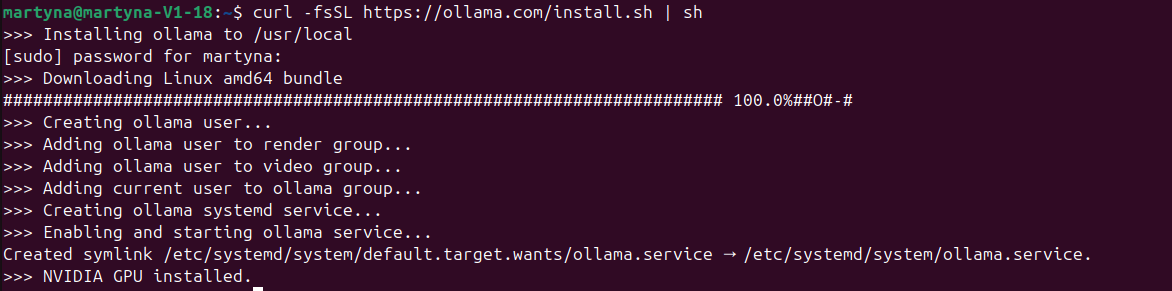

Then, let's pull model that seems interesting to us (I use llama 3.2):

https://ollama.com/library/llama3.2:3b

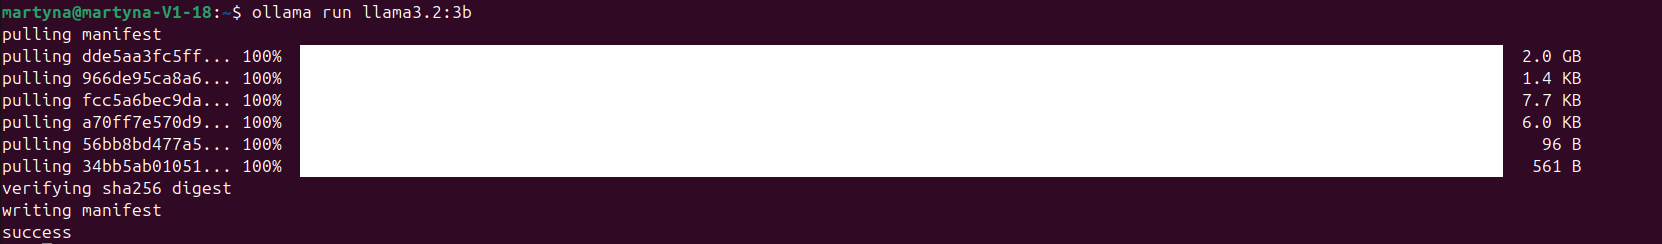

And just to let you know - you can already talk with your model from your terminal: 



We're going to use Reddit as our search source, so let's create an account and search-tool. 

Here big thanks for James Briggs and his tutorial: https://towardsdatascience.com/how-to-use-the-reddit-api-in-python-5e05ddfd1e5c

We'll be using `praw` library which is a Python Reddit API Wrapper - much easier than using `requests`. 

In [5]:
import praw 

reddit = praw.Reddit(
    client_id="xLBPF8sJ1DXLgF15gW-nJA",  # personal use script
    client_secret="SESfsRqReWV2M8gxxhwRJwI8VGcFYg",  # secret key
    user_agent="search-tool"  # name of your app
)

Version 7.7.1 of praw is outdated. Version 7.8.0 was released 1 day ago.


We will be extracting submission threads from Reddit, focusing on gathering restaurant recommendations or other relevant details based on our search criteria. For each submission thread, we'll need to capture:

The submission title
The first text or description of the submission
A few of the top-voted comments
To organize this information, we can define a Pydantic class to structure the required data. Here's an example of how the class might look:

In [16]:
from pydantic import BaseModel
from typing import List
from praw.models import Comment
from datetime import datetime, timezone


class Rec(BaseModel):
    title: str
    description: str
    comments: List[str]
    
    def __str__(self):
        """LLM-friendly string representation of the recommendation(s)."""
        return f"Title: {self.title}\nDescription: {self.description}\nComments:\n{'\n'.join(self.comments)}"

Now let's setup the retrieval logic for an example query `house prices in Poland`:

In [39]:
def search(query: str) -> List[Rec]:
    """
    Searches Reddit for posts related to house prices in Poland using a Polish query.
    Retrieves the top 12 submissions from the current year based on the number of overall votes (upvotes - downvotes).
    """
    current_year = datetime.now(timezone.utc).year
    # Search in a specific subreddit for more relevant results
    results = reddit.subreddit("Polska").search(query, time_filter="year", sort="new")
    recs = []
    
    for submission in results:
        # Ensure the post is from the current year
        submission_year = datetime.fromtimestamp(submission.created_utc, tz=timezone.utc).year
        if submission_year == current_year:
            title = submission.title
            description = submission.selftext if submission.selftext else "(Link Post - No Description)"
            comments = []
            for comment in submission.comments.list():
                if isinstance(comment, Comment) and comment.ups >= 20: 
                    author = comment.author.name if comment.author else "unknown"
                    comments.append(f"{author} (upvotes: {comment.ups}): {comment.body}")
            comments = comments[:5]  # Keep the top 5 comments
            
            # Additional filter: Ensure the post mentions something related to house prices
            if any(keyword in title.lower() for keyword in ["ceny mieszkań", "ceny", "cena mieszkania", "m2", "mieszkanie", "mieszkań", "mieszkaniowa", "kredyt 0"]):
                if len(comments) >= 3:
                    recs.append(Rec(title=title, description=description, comments=comments))

    # Sort by the number of votes (upvotes - downvotes) and return the top 12 results
    recs = sorted(recs, key=lambda x: submission.score, reverse=True)[:12]
    
    return recs


query = "ceny mieszkań w Polsce"
search_results = search(query)
search_results

[Rec(title='Chore ceny mieszkań w Polsce. "Drogie kredyty ich nie zatrzymają"', description='(Link Post - No Description)', comments=['MilkshakeYeah (upvotes: 70): "ekspert finansowy Karol Słobodzian" żyje ze sprzedaży kredytów i obrotu nieruchomościami, to co ma mówić? W dodatku taki z niego ekspert jak z koziej dupy trąba xD [https://www.instagram.com/ekspertfinansowyslo/?hl=en](https://www.instagram.com/ekspertfinansowyslo/?hl=en)   \n[https://www.linkedin.com/in/slobodziankarol/details/certifications/](https://www.linkedin.com/in/slobodziankarol/details/certifications/)  \n[https://karolslobodzian.pl](https://karolslobodzian.pl)', 'Reeposter (upvotes: 23): Dosłownie za każdym jebanhm artykułem o rynku nieruchomości, wcześniej co drugi artykuł ekspertem było HRE Investments', 'nonflux (upvotes: 20): Chyba deweloperzy opłacają ekstra artykuły, że taniej nie będzie, bo pod tyłkami się im pali. Największa dostępność mieszkań od kilku lat, stopy dalej wysokie, no ceny tylko do góry. /s'

In [40]:
print("\n===\n".join([str(rec) for rec in search_results]))

Title: Chore ceny mieszkań w Polsce. "Drogie kredyty ich nie zatrzymają"
Description: (Link Post - No Description)
Comments:
MilkshakeYeah (upvotes: 70): "ekspert finansowy Karol Słobodzian" żyje ze sprzedaży kredytów i obrotu nieruchomościami, to co ma mówić? W dodatku taki z niego ekspert jak z koziej dupy trąba xD [https://www.instagram.com/ekspertfinansowyslo/?hl=en](https://www.instagram.com/ekspertfinansowyslo/?hl=en)   
[https://www.linkedin.com/in/slobodziankarol/details/certifications/](https://www.linkedin.com/in/slobodziankarol/details/certifications/)  
[https://karolslobodzian.pl](https://karolslobodzian.pl)
Reeposter (upvotes: 23): Dosłownie za każdym jebanhm artykułem o rynku nieruchomości, wcześniej co drugi artykuł ekspertem było HRE Investments
nonflux (upvotes: 20): Chyba deweloperzy opłacają ekstra artykuły, że taniej nie będzie, bo pod tyłkami się im pali. Największa dostępność mieszkań od kilku lat, stopy dalej wysokie, no ceny tylko do góry. /s
===
Title: Ceny mi

## Final Answer "Tool"

Alongside our web search tool we will have a final tool called `final_answer`. 

The final answer tool will be called whenever the LLM has finished pulling info from the other two tools and is ready to provide a *final answer* to the user.

In [38]:
def final_answer(answer: str, avg_price: str = "", location: str = "") -> dict:
    """
    Returns a natural language response to the user. The response contains:
    - `answer`: the natural language response to the query about house prices in Poland.
    - `avg_price`: the average price (if found).
    - `location`: the location or region in Poland where prices were discussed (if found).
    """
    return {
        "answer": answer,
        "avg_price": avg_price,
        "location": location,
    }

## Graph Construction

### Agent State

In [30]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    output: dict[str, Union[str, List[str]]]

### LLM

The LLM acts as our decision maker and generator of our final output. For this we are using Ollama and `llama 3.2`.

Note: Ollama tool-calling at the moment is not able to call more than one tool at the time. 

In [41]:
system_prompt = """You are a real estate agent in Poland. A client has asked you about the current house prices in Poland.
Given the user's query you must decide what to do with it based on the list of tools provided to you. 

Your goal is to provide the user with the most relevant information about house prices in Poland. 
Including the average price and the location where the prices were discussed.

Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool and the response format must ALWAYS be in the pattern:

```json
{
    "name": "<tool_name>",
    "parameters": {
        "<tool_input_key>": "<tool_input_value>"
    }
}
```
Remember, NEVER use the search tool more than 3x as that can lead to a ban from the Reddit API.

After using the search tool you must summarize your findings with the final_answer tool. 
Note, if the user asks a question or says something unrelated to house prices, you must use the final_answer tool directly."""